## **Series de tiempo**

*Parte 3*

En esta última práctica guiada de series de tiempo trabajaremos con el dataset de temperaturas de la Ciudad Autónoma de Buenos Aires -ya transformado a partir del análisis de la Práctica_01-.

Dividiremos el noteebok en 3 apartados:

1. One-step

2. Multi-step

3. Prophet

## **1. One-step**

La principal adaptación que se necesita hacer para aplicar modelos de Machine Learning a problemas de forecasting -proceso que consiste en predecir el valor futuro de una serie temporal- es transformar la serie temporal en un matriz en la que cada valor está asociado a la ventana temporal (lags) que le precede. Esto significa que, para cada predicción, se utilizan como predictores las temperaturas de la cantidad de semanas establecidas como lags.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [33]:
data = pd.read_csv(r'..\Datasets\Clase_04_temperatura_transf.csv')

In [34]:
data.head(3)

,fecha,Tmax,Tmin,Tmean
0,1959-01-04,26.125,15.850000,20.987500
1,1959-01-11,26.600,12.785714,19.692857
2,1959-01-18,28.300,16.885714,22.592857


In [35]:
data['fecha'] = pd.to_datetime(data.fecha)

In [36]:
data.set_index('fecha', inplace = True)

In [37]:
# Nos quedamos solamente con la variable que queremos predecir

senial = data.Tmean

In [38]:
senial

fecha
1959-01-04    20.987500
1959-01-11    19.692857
1959-01-18    22.592857
1959-01-25    23.850000
1959-02-01    21.823810
                ...    
2018-05-20    14.050000
2018-05-27    15.292857
2018-06-03    14.542857
2018-06-10    11.935714
2018-06-17    11.133333
Name: Tmean, Length: 3103, dtype: float64

In [39]:
#  Usamos x semanas para predecir el valor siguiente

look_back = 2*52 # En este caso, utilizaremos 2 años

In [40]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(2998, 104) (2998,)


In [41]:
# Llenamos los X e Y

for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [42]:
N_train = 10*52 - look_back  # Cantidad de instancias anteriores que vamos a usar para entrenar el modelo. Elegimos 10 años
N_test = 4*52  # Cantidad de instancias que vamos a usar para evaluar el modelo. Elegimos 4 años
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print('Shape de x e y en el set de entrenamiento:', X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print('Shape de x e y en el set de testeo:', X_test.shape, y_test.shape)

Shape de x e y en el set de entrenamiento: (416, 104) (416,)
Shape de x e y en el set de testeo: (208, 104) (208,)


In [43]:
# Entrenamos un árbol de decisión
# ==============================================================================
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth= 4, random_state=42)

tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

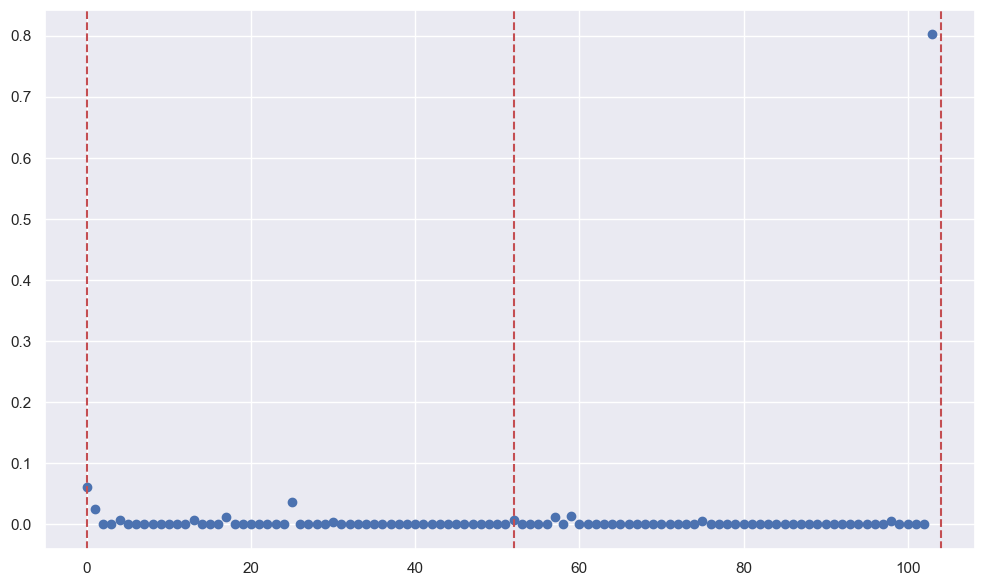

In [44]:
# Ploteamos la importancia de los atributos

plt.figure(figsize = (12,7))
plt.scatter(np.arange(tree_reg.feature_importances_.size),tree_reg.feature_importances_)
for x in np.arange(3)*52:
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [45]:
# En esta parte predecimos
# ==============================================================================

y_pred = tree_reg.predict(X)
y_train_pred = tree_reg.predict(X_train)
y_test_pred = tree_reg.predict(X_test)

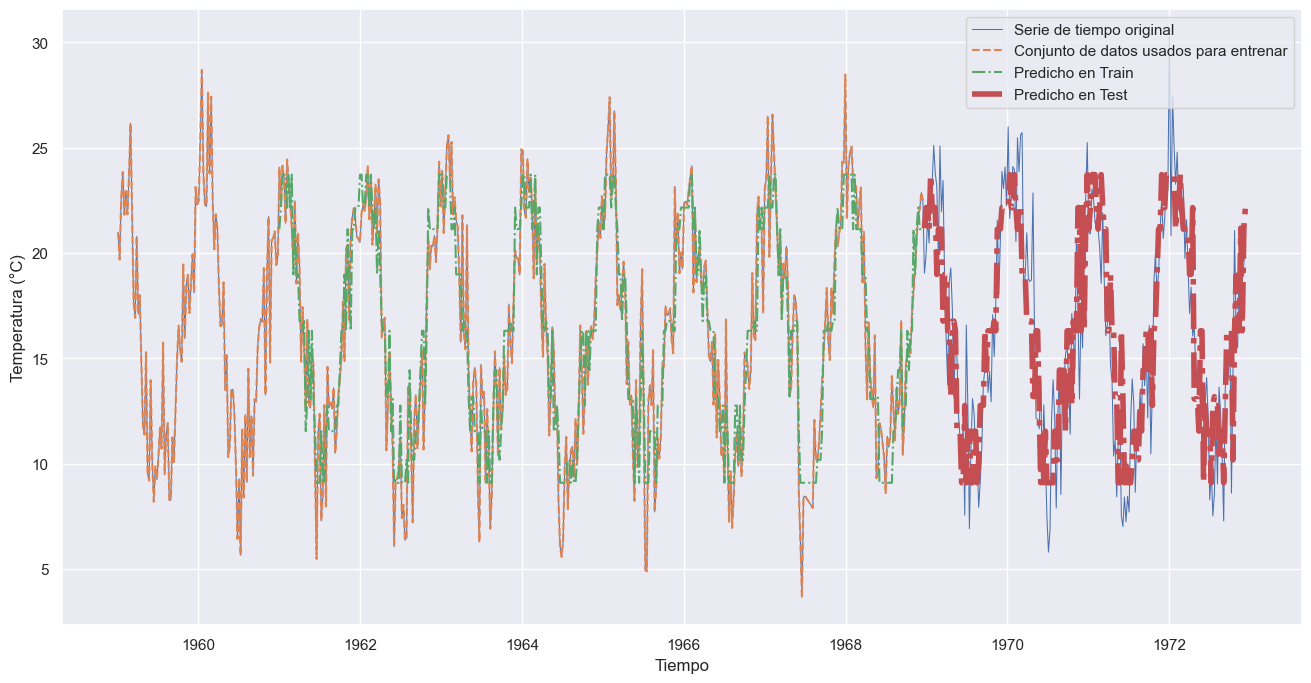

In [46]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie de tiempo original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Conjunto de datos usados para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.show()

In [47]:
# Evaluamos el modelo
# ==============================================================================

MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train,RMSE:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test,RMSE:',np.sqrt(MSE))

Error en Train,RMSE: 2.0092702724200717
Error en Test,RMSE: 3.0748113205772483


## **2. Multi-step**

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento -step- de la serie (t+1), sino todo un intervalo futuro o un punto alejado en el tiempo (t+n). A cada paso de la predicción se le conoce como step.

Tenemos dos métodos para aplicar Multi-step. Uno se llama `recursivo` y el otro `directo`. La predicción recursiva se basa en la predicción anterior hecha por el modelo, mientras que el método directo entrena un modelo diferente para cada uno de lo steps que se desea predecir. 


En el recursivo, si establecemos una ventana temporal -o ventana de predictores- de 10 para predecir, el valor t+1 va a tomar en cuenta las 10 semanas anteriores. Ahora bien, cuando queramos predecir el segundo step (t+2), en los 10 lags que utiliza el modelo para predecir va a considerar t+1 -o sea, un valor que no es real sino predicho-. Y así sucesivamente. En el método directo, en cambio, si quisiéramos predecir el resultado de las próximas 10 semanas de una serie, se entrenarán 10 modelos diferentes. Este método es mucho más costoso computacionalmente porque requiere entrenar varios modelos (uno para cada step -predicción-).

***`Método recursivo`***

<img src = "https://www.cienciadedatos.net/images/diagrama-multistep-recursiva.png" height = 300>

+ Ventajas: solo hay que entrenar un modelo.

+ Desventajas : cuanto más nos alejamos de los datos medidos, más probable que se acumulen errores

***`Método directo`***

<img src = "https://www.cienciadedatos.net/images/diagrama-prediccion-multistep-directa.png" height = 300>

+ Ventajas: no acumula error

+ Desventajas : hay que crear un modelo para cada paso. Tendremos tantos modelos como cantidad de semanas -en este caso- queramos predecir

### **Método recursivo**

Empecemos con el método recursivo. Crearemos y entrenaremos un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de árbol de decisión y una ventana temporal de 14 semanas (14 lags). Esto último significa que, para cada predicción, se utilizan como predictores los niveles de temperaturas de las 14 semanas anteriores.

In [48]:
#pip install skforecast

In [49]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

In [50]:
senial

fecha
1959-01-04    20.987500
1959-01-11    19.692857
1959-01-18    22.592857
1959-01-25    23.850000
1959-02-01    21.823810
                ...    
2018-05-20    14.050000
2018-05-27    15.292857
2018-06-03    14.542857
2018-06-10    11.935714
2018-06-17    11.133333
Name: Tmean, Length: 3103, dtype: float64

In [51]:
senial = senial.asfreq('W') # Multi-step necesita un índice que especifique la frecuencia

In [52]:
senial.index

DatetimeIndex(['1959-01-04', '1959-01-11', '1959-01-18', '1959-01-25',
               '1959-02-01', '1959-02-08', '1959-02-15', '1959-02-22',
               '1959-03-01', '1959-03-08',
               ...
               '2018-04-15', '2018-04-22', '2018-04-29', '2018-05-06',
               '2018-05-13', '2018-05-20', '2018-05-27', '2018-06-03',
               '2018-06-10', '2018-06-17'],
              dtype='datetime64[ns]', name='fecha', length=3103, freq='W-SUN')

Fechas train : 1959-01-04 00:00:00 --- 2014-06-22 00:00:00  (n=2895)
Fechas test  : 2014-06-29 00:00:00 --- 2018-06-17 00:00:00  (n=208)


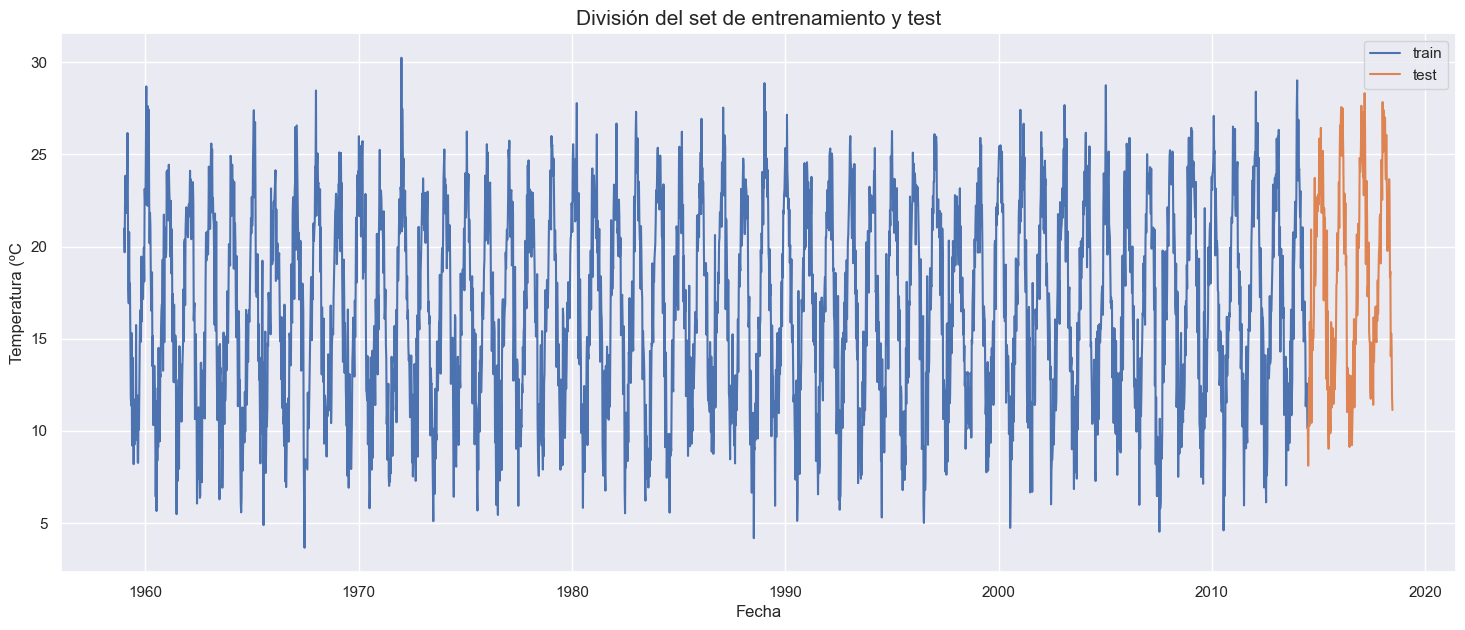

In [53]:
# Separación de datos en set de entrenamiento y testeo
# ==============================================================================

steps = 52*4 # Cantidad de semanas que usaremos para testear
datos_train = senial[:-steps]
datos_test  = senial[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

plt.subplots(figsize=(18, 7))
plt.plot(datos_train, label='train')
plt.plot(datos_test, label='test')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (ºC')
plt.title('División del set de entrenamiento y test', fontsize = 15)
plt.legend()
plt.show()

In [54]:
# Fijamos, en lags, la ventana temporal que considerará el modelo para hacer sus predicciones

forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(random_state=42), lags = 14)

forecaster.fit(y= datos_train)
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1959-01-04 00:00:00'), Timestamp('2014-06-22 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2023-12-14 13:09:42 
Last fit date: 2023-12-14 13:09:42 
Skforecast version: 0.9.1 
Python version: 3.10.0 
Forecaster id: None 

In [55]:
# Una vez entrenado el modelo, se predicen los datos de test (valor fijado en steps cuando separamos los datos en train/test)

# Predicciones
# ==============================================================================

predicciones = forecaster.predict(steps= steps)
predicciones.head(5)

2014-06-29    11.685714
2014-07-06    10.992857
2014-07-13     6.057143
2014-07-20     7.435714
2014-07-27     7.878571
Freq: W-SUN, Name: pred, dtype: float64

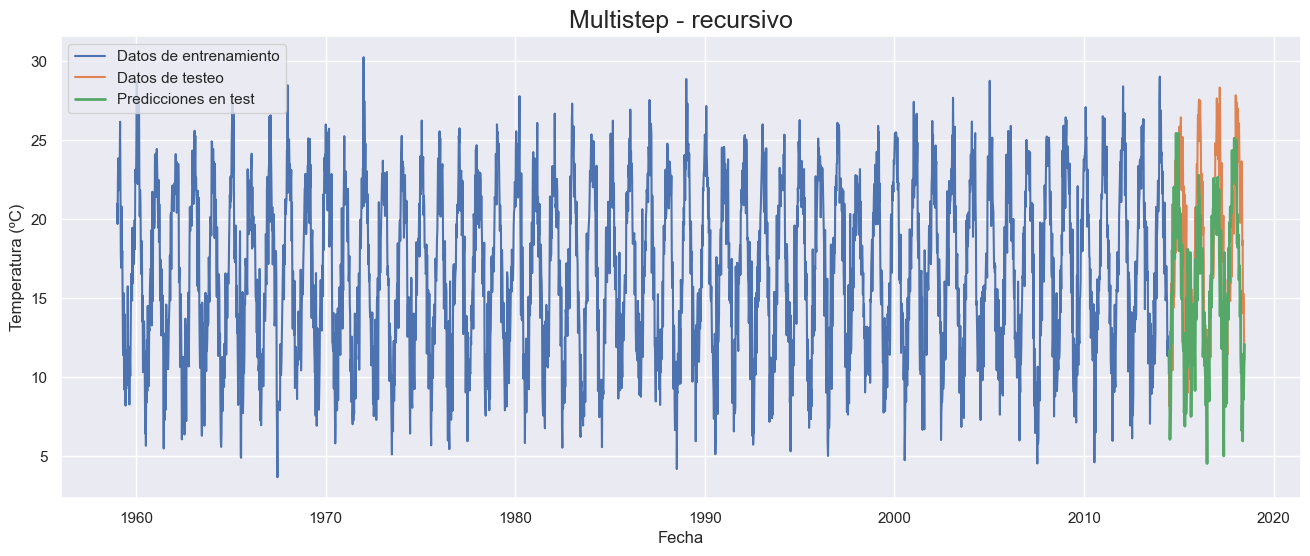

In [56]:
plt.subplots(figsize=(16, 6))
plt.plot(datos_train, label='Datos de entrenamiento',)
plt.plot(datos_test, label='Datos de testeo')
plt.plot(predicciones, label='Predicciones en test', lw= 2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura (ºC)')
plt.title('Multistep - recursivo', fontsize = 18)
plt.legend()
plt.show()

In [57]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test, y_pred = predicciones, squared= False)

print(f"Error de test (RMSE): {error_mse}")

Error de test (RMSE): 5.585375017705508


### **Método directo**

In [58]:
#pip install skforecast

In [59]:
# from sklearn.tree import DecisionTreeRegressor
# from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
# forecaster = ForecasterAutoregCustom(regressor = DecisionTreeRegressor(random_state=42),steps= steps, lags= 14)

# forecaster.fit(y=datos_train)
# forecaster

In [60]:
#usar abol de decicsion y forecasterautoregcustom

predicciones = forecaster.predict(steps= steps)
predicciones.head(5)


2014-06-29    11.685714
2014-07-06    10.992857
2014-07-13     6.057143
2014-07-20     7.435714
2014-07-27     7.878571
Freq: W-SUN, Name: pred, dtype: float64

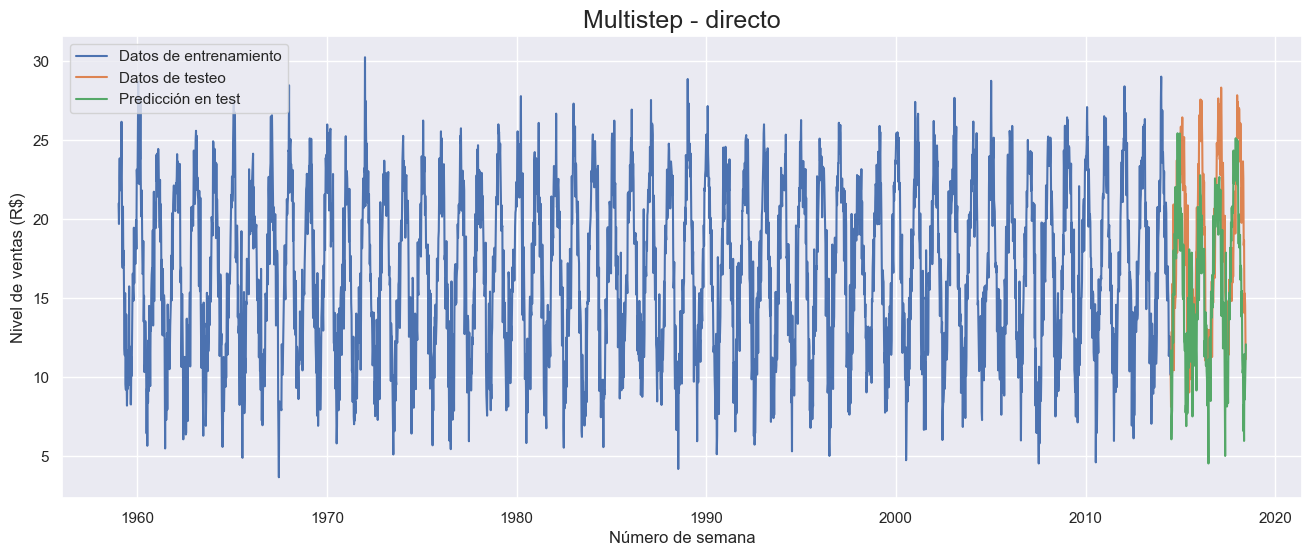

In [61]:
# Predecimos
# ==============================================================================

# Ploteamos
# ==============================================================================
plt.subplots(figsize=(16, 6))
plt.plot(datos_train, label='Datos de entrenamiento')
plt.plot(datos_test, label='Datos de testeo')
plt.plot(predicciones, label='Predicción en test')
plt.title('Multistep - directo', fontsize = 18)
plt.xlabel('Número de semana')
plt.ylabel('Nivel de ventas (R$)')
plt.legend()
plt.show()

In [62]:
# Evaluación del modelo
# ==============================================================================

error_mse = mean_squared_error(y_true = datos_test, y_pred = predicciones, squared= False)
print(f"Error de test (RMSE) : {(error_mse)}")

Error de test (RMSE) : 5.585375017705508


## **3. Prophet**

Prophet utiliza un modelo de regresión aditiva para descomponer la serie temporal en varios componentes: la tendencia, la estacionalidad, los festivos y el error:

$$y(t) = g(t) + s(t) + h(t) + e(t)$$

- $g(t)$ es la tendencia, que representa los cambios no periódicos que se modelizarán asumiendo una relación lineal o logística.

- $s(t)$ es la estacionalidad, que representa cambios periódicos: semanales, mensuales, anuales, etc.

- $h(t)$ es el efecto de los festivos, que pueden aparecer de manera irregular y tener una duración de 1 día o más.

- $e(t)$ es el término de error, que representa cambios *idiosincrásicos* que no se pueden acomodar al modelo. Se asume que estos errores deben tener una distribución normal.

Prophet utiliza el ajuste de curvas para descomponer las series de tiempo, teniendo en cuenta la estacionalidad en múltiples escalas de tiempo, efectos de vacaciones, puntos de cambio abruptos y tendencias a largo plazo.

In [63]:
# pip install Prophet

In [64]:
from prophet import Prophet

In [65]:
# Prophet trabaja la columna fecha con el nombre 'ds' y la columna con las etiquetas con el nombre 'y'

data.reset_index(level= 0, inplace= True)
data.rename(columns= {'fecha': 'ds', 'Tmean' : 'y'}, inplace = True)
data.drop(columns= ['Tmax', 'Tmin'], inplace= True)

In [66]:
# Instanciamos un modelo de Prophet

prophet = Prophet(yearly_seasonality= True, uncertainty_samples = 50, mcmc_samples=50, interval_width= 0.6)

# Entrenamos el modelo
prophet.fit(data)

# Construimos un dataframe con los x valores futuros que querámos predecir. En este caso, 4 años.
build_forecast = prophet.make_future_dataframe(periods=(4*52), freq='W') #

# Predecimos
forecast = prophet.predict(build_forecast)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None


cmdstanpy  DEBUG Adding TBB (c:\Users\Mario_Suaza\.conda\envs\DataScience\lib\site-packages\prophet\stan_model\cmdstan-2.31.0\stan\lib\stan_math\lib\tbb) to PATH
prophet    INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\pquv3w82.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\fwkp2op6.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:09:44 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=99354', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\pquv3w82.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\fwkp2op6.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model1osp0ad4\\prophet_model-20231214130945_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:09:49 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=99354', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\pquv3w82.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\fwkp2op6.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model1osp0ad4\\prophet_model-20231214130945_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model1osp0ad4\prophet_model-20231214130945_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

In [ ]:
# plot forecasts

prophet.plot(forecast, xlabel='Fecha', ylabel='Temperatura (ºC)', figsize = (16,6))
plt.title('Predicción de temperatura (ºC) en CABA para los próximos 4 años de nuestro dataset', fontsize = 18)
plt.show()

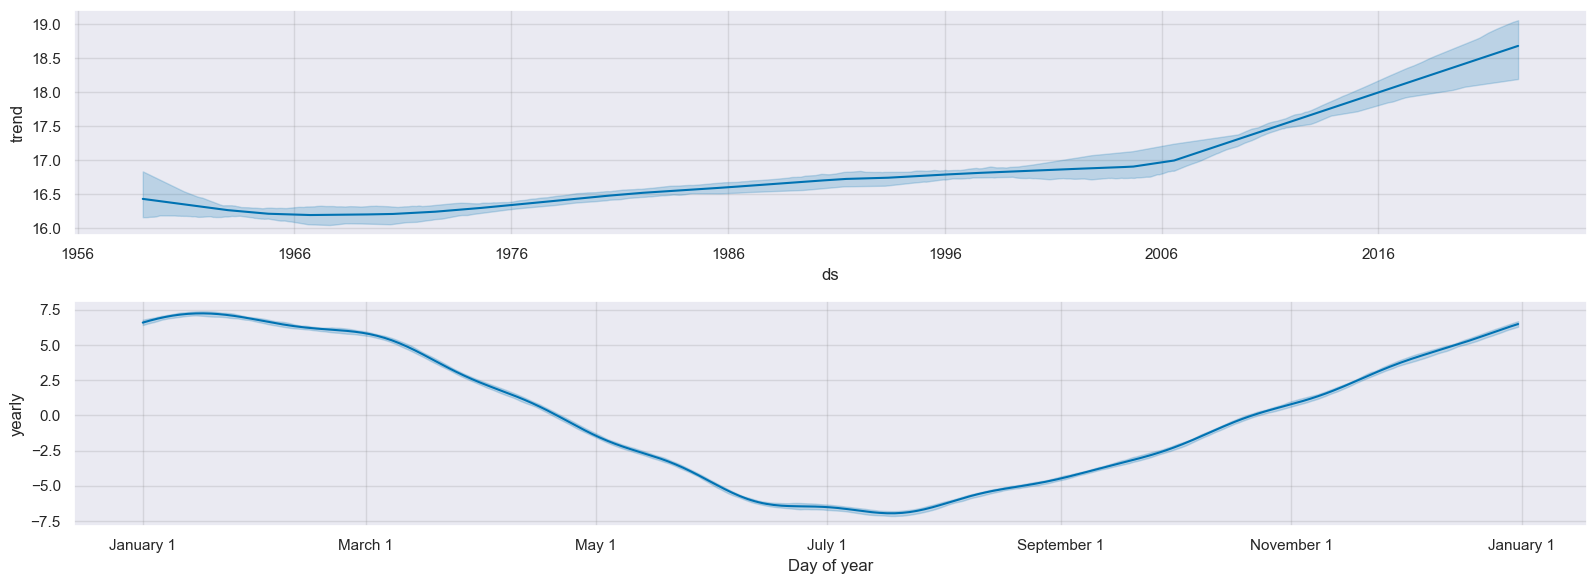

In [ ]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet.plot_components(forecast, figsize=(16,6))

### **Evaluación del modelo**

In [68]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [69]:
df_cv = cross_validation(prophet, horizon = '1460 days')

prophet    INFO  Making 22 forecasts with cutoffs between 1972-06-28 00:00:00 and 2014-06-18 00:00:00


  0%|          | 0/22 [00:00<?, ?it/s]

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\e7oj6x48.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\igx_wgjx.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:02 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=1438', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\e7oj6x48.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\igx_wgjx.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model6ohi2rpm\\prophet_model-20231214131102_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=

13:11:02 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=1438', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\e7oj6x48.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\igx_wgjx.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model6ohi2rpm\\prophet_model-20231214131102_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model6ohi2rpm\prophet_model-20231214131102_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_m

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\van8gc9f.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\84v1csbq.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:03 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=96485', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\van8gc9f.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\84v1csbq.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeluy_ehm09\\prophet_model-20231214131103_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=3', 'random', 'seed=96485', 'data', 'file=C:\\Us

13:11:04 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=96485', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\van8gc9f.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\84v1csbq.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeluy_ehm09\\prophet_model-20231214131103_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modeluy_ehm09\prophet_model-20231214131103_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\j7oau8tz.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\_aanynxe.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:04 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=4', 'random', 'seed=84877', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\j7oau8tz.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\_aanynxe.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model4a4zxau5\\prophet_model-20231214131104_4.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=3', 'random', 'seed=84877', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\

13:11:05 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=84877', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\j7oau8tz.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\_aanynxe.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model4a4zxau5\\prophet_model-20231214131104_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model4a4zxau5\prophet_model-20231214131104_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\gkpbbvr8.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\powz23pu.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:05 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=9070', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\gkpbbvr8.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\powz23pu.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelxb5o0__w\\prophet_model-20231214131105_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=

13:11:07 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=9070', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\gkpbbvr8.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\powz23pu.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelxb5o0__w\\prophet_model-20231214131105_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelxb5o0__w\prophet_model-20231214131105_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_m

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\5n6r2obi.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\9rwklvgk.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:07 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=52385', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\5n6r2obi.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\9rwklvgk.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model3cvxanra\\prophet_model-20231214131107_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=52385', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\

13:11:08 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=52385', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\5n6r2obi.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\9rwklvgk.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model3cvxanra\\prophet_model-20231214131107_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model3cvxanra\prophet_model-20231214131107_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\vxniehm6.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\pfjv_2vw.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:08 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=31623', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\vxniehm6.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\pfjv_2vw.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeltg9cuptu\\prophet_model-20231214131108_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:10 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=31623', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\vxniehm6.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\pfjv_2vw.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeltg9cuptu\\prophet_model-20231214131108_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modeltg9cuptu\prophet_model-20231214131108_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\8rjqbiuf.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\xzhl3foz.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:10 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=3', 'random', 'seed=44250', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\8rjqbiuf.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\xzhl3foz.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model9_uqyowi\\prophet_model-20231214131110_3.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=44250', 'data', 'file=C:\\Us

13:11:12 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=44250', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\8rjqbiuf.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\xzhl3foz.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model9_uqyowi\\prophet_model-20231214131110_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model9_uqyowi\prophet_model-20231214131110_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\yo8gsbjf.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\tpw4h7q_.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:12 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=14641', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\yo8gsbjf.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\tpw4h7q_.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelca9_yj1_\\prophet_model-20231214131112_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:14 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=14641', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\yo8gsbjf.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\tpw4h7q_.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelca9_yj1_\\prophet_model-20231214131112_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelca9_yj1_\prophet_model-20231214131112_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\75le9_jv.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\u26fz4w5.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:14 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=69996', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\75le9_jv.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\u26fz4w5.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeln_4ma192\\prophet_model-20231214131114_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:16 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=69996', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\75le9_jv.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\u26fz4w5.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeln_4ma192\\prophet_model-20231214131114_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modeln_4ma192\prophet_model-20231214131114_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\mqumg4jr.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\9kf31wzt.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:17 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=59765', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\mqumg4jr.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\9kf31wzt.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelmvxgfamz\\prophet_model-20231214131117_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=3', 'random', 'seed=59765', 'data', 'file=C:\\Us

13:11:19 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=59765', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\mqumg4jr.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\9kf31wzt.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelmvxgfamz\\prophet_model-20231214131117_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelmvxgfamz\prophet_model-20231214131117_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\7is79smj.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\j_du8azx.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:19 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=95840', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\7is79smj.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\j_du8azx.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model_snj0fg_\\prophet_model-20231214131119_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=95840', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\7is79smj.json', 'init=

13:11:22 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=95840', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\7is79smj.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\j_du8azx.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model_snj0fg_\\prophet_model-20231214131119_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model_snj0fg_\prophet_model-20231214131119_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\3d9v35us.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\uigtgf2q.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:22 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=63690', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\3d9v35us.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\uigtgf2q.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelzzclywrf\\prophet_model-20231214131122_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:24 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=63690', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\3d9v35us.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\uigtgf2q.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelzzclywrf\\prophet_model-20231214131122_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelzzclywrf\prophet_model-20231214131122_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\mr_kjeox.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\5yc83n3d.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:24 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=74951', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\mr_kjeox.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\5yc83n3d.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelm1byez28\\prophet_model-20231214131124_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:27 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=74951', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\mr_kjeox.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\5yc83n3d.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelm1byez28\\prophet_model-20231214131124_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelm1byez28\prophet_model-20231214131124_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\7o4q5dxj.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\jr8rh78z.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:27 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=86493', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\7o4q5dxj.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\jr8rh78z.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelwm87uvj7\\prophet_model-20231214131127_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:30 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=86493', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\7o4q5dxj.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\jr8rh78z.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelwm87uvj7\\prophet_model-20231214131127_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelwm87uvj7\prophet_model-20231214131127_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\hmptx4w4.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\xt3p2nma.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:31 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=3', 'random', 'seed=85572', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\hmptx4w4.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\xt3p2nma.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelud8ato25\\prophet_model-20231214131131_3.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=85572', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\hmptx4w4.json', 'init=C:\\Users\\MARIO_~1\\Ap

13:11:35 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=85572', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\hmptx4w4.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\xt3p2nma.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelud8ato25\\prophet_model-20231214131131_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelud8ato25\prophet_model-20231214131131_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\ib60kw42.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\s1wivvac.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:36 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=72234', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\ib60kw42.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\s1wivvac.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model0di5ce_7\\prophet_model-20231214131136_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=72234', 'data', 'file=C:\\Us

13:11:38 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=72234', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\ib60kw42.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\s1wivvac.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model0di5ce_7\\prophet_model-20231214131136_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model0di5ce_7\prophet_model-20231214131136_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\foz7fm_n.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\94b7cvow.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:39 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=31074', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\foz7fm_n.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\94b7cvow.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelklaw_nce\\prophet_model-20231214131139_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=31074', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\foz7fm_n.json', 'init=C:\\Users\\MARIO_~1\\Ap

13:11:40 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=31074', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\foz7fm_n.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\94b7cvow.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelklaw_nce\\prophet_model-20231214131139_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelklaw_nce\prophet_model-20231214131139_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\k6z5_ilq.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\larsg6g8.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:40 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=84237', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\k6z5_ilq.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\larsg6g8.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelrdsf2mom\\prophet_model-20231214131140_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:44 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=84237', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\k6z5_ilq.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\larsg6g8.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelrdsf2mom\\prophet_model-20231214131140_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelrdsf2mom\prophet_model-20231214131140_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\bcoru7va.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\8ryyy1as.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:45 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=66713', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\bcoru7va.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\8ryyy1as.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeladgcx8ki\\prophet_model-20231214131145_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:48 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=66713', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\bcoru7va.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\8ryyy1as.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modeladgcx8ki\\prophet_model-20231214131145_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modeladgcx8ki\prophet_model-20231214131145_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\bcxowd4q.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\yyehu_sl.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:48 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=42135', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\bcxowd4q.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\yyehu_sl.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model5jyk95fn\\prophet_model-20231214131148_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:51 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=42135', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\bcxowd4q.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\yyehu_sl.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_model5jyk95fn\\prophet_model-20231214131148_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_model5jyk95fn\prophet_model-20231214131148_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\84pv6_rg.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\mw1aygij.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:52 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=36764', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\84pv6_rg.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\mw1aygij.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelcry6eud_\\prophet_model-20231214131152_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=2', 'random', 'seed=36764', 'data', 'file=C:\\Us

13:11:56 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=36764', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\84pv6_rg.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\mw1aygij.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelcry6eud_\\prophet_model-20231214131152_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelcry6eud_\prophet_model-20231214131152_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\dipcktyc.json
cmdstanpy  DEBUG input tempfile: C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\tyef3iet.json
cmdstanpy  DEBUG cmd: C:\Users\Mario_Suaza\.conda\envs\DataScience\Lib\site-packages\prophet\stan_model\prophet_model.bin info
cwd: None
13:11:56 - cmdstanpy - INFO - CmdStan start processing
cmdstanpy  INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG idx 1
cmdstanpy  DEBUG idx 2
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG idx 3
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=22026', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\dipcktyc.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\tyef3iet.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelilyfppgl\\prophet_model-20231214131156_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
cmdstanpy  DEBUG running CmdStan, num_threads: 1
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id

13:11:59 - cmdstanpy - INFO - CmdStan done processing.
cmdstanpy  INFO  CmdStan done processing.
cmdstanpy  DEBUG runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Mario_Suaza\\.conda\\envs\\DataScience\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'id=1', 'random', 'seed=22026', 'data', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\dipcktyc.json', 'init=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\tyef3iet.json', 'output', 'file=C:\\Users\\MARIO_~1\\AppData\\Local\\Temp\\tmpk94op643\\prophet_modelilyfppgl\\prophet_model-20231214131156_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_modelilyfppgl\prophet_model-20231214131156_1.csv
 console_msgs (if any):
	C:\Users\MARIO_~1\AppData\Local\Temp\tmpk94op643\prophet_

In [70]:
df_cv
# graficar df_cv con y el dataset data
# Path: Práctica_03.ipynb
# df_cv.plot(x='x', y='y', kind='scatter', title='Datos de entrenamiento y validación')
# plt.show()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1972-07-02,9.874714,8.343050,12.057840,8.285714,1972-06-28
1,1972-07-09,9.976960,7.240207,11.414211,9.728571,1972-06-28
2,1972-07-16,10.079334,8.495051,11.815419,7.525000,1972-06-28
3,1972-07-23,10.321791,8.605979,11.896082,8.541667,1972-06-28
4,1972-07-30,10.730695,9.086759,12.661246,11.975000,1972-06-28
...,...,...,...,...,...,...
4584,2018-05-20,14.140293,12.418543,16.191666,14.050000,2014-06-18
4585,2018-05-27,13.280060,11.008702,15.058386,15.292857,2014-06-18
4586,2018-06-03,12.302420,10.594164,13.642290,14.542857,2014-06-18
4587,2018-06-10,11.492311,9.509511,13.421553,11.935714,2014-06-18


In [71]:
#grafica serie df_cv

In [72]:
df_p = performance_metrics(df_cv)
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,1315,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
mean,803 days 00:00:00,4.888630,2.196773,1.733890,0.120169,0.090021,0.115050,0.618808
std,379 days 18:03:02.487971772,1.114224,0.250728,0.206641,0.044074,0.030436,0.039147,0.049611
min,146 days 00:00:00,3.301640,1.817042,1.425938,0.068036,0.053833,0.067972,0.531295
25%,474 days 12:00:00,3.822932,1.955232,1.535790,0.077626,0.063997,0.076937,0.573872
50%,803 days 00:00:00,4.763451,2.182533,1.724684,0.108394,0.079501,0.105541,0.618632
75%,1131 days 12:00:00,5.862895,2.421341,1.912043,0.163373,0.115705,0.152256,0.665939
max,1460 days 00:00:00,7.238607,2.690466,2.141496,0.199640,0.156652,0.182718,0.701601


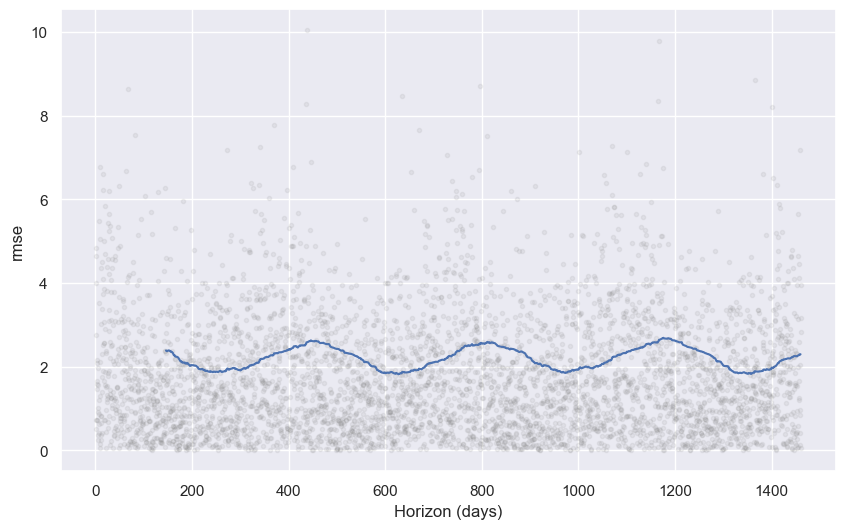

In [73]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [74]:
print('El RMSE es:', df_p.rmse.mean())

El RMSE es: 2.1967733353532046


In [75]:
df_p = performance_metrics(df_cv, rolling_window = 1)

In [76]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1460 days,5.032046,2.243222,1.758809,0.125794,0.084633,0.119808,0.611898


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Simulación de datos de precios del cerdo
np.random.seed(0)
num_samples = 100
time_steps = np.arange(0, num_samples)
actual_prices = np.random.uniform(1.4, 1.5, size=num_samples)

# Preparación de datos para LSTM (one step ahead)
data = actual_prices[:-1] # Todos los datos menos el último
targets = actual_prices[1:] # Todos los datos menos el primero
 
# Reshape de los datos para el formato LSTM (samples, time_steps, features) 
data = data.reshape(-1, 1, 1) # (99, 1, 1)
targets = targets.reshape(-1, 1) # (99, 1)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(1, 1)))
model.add(Dense(1))

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(data, targets, epochs=50, batch_size=8)

# Predicción one step ahead
last_price = actual_prices[-2]
next_prediction = model.predict(np.array([[last_price]]))
print("Predicción para el siguiente valor:", next_prediction)

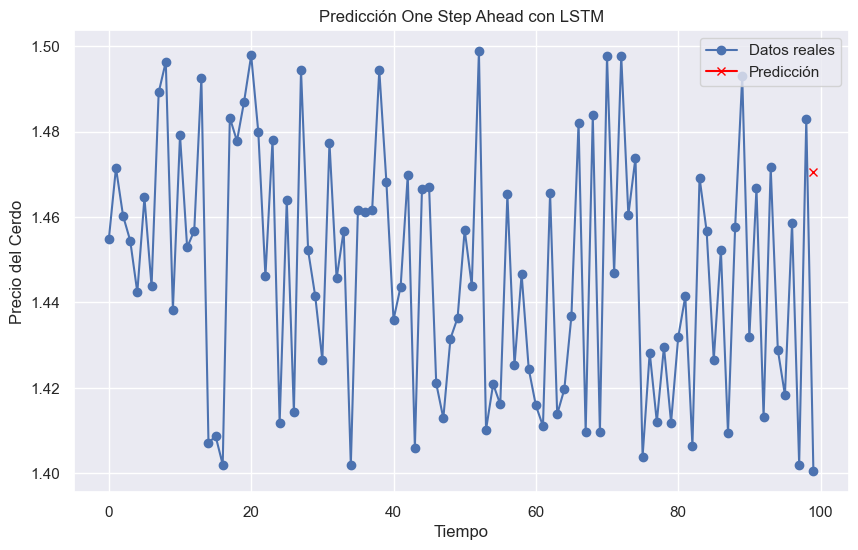

In [ ]:
# Crear una gráfica de datos y predicción
plt.figure(figsize=(10, 6))
plt.plot(time_steps, actual_prices, label='Datos reales', marker='o')
plt.plot(time_steps[-1], next_prediction, label='Predicción', marker='x', color='red')
plt.xlabel('Tiempo')
plt.ylabel('Precio del Cerdo')
plt.title('Predicción One Step Ahead con LSTM')
plt.legend()
plt.show()